In [53]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import psd_array_welch

# Single Patient Validation

In [54]:
print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1., 4.
event_id = dict(left=2, right=3)
subject = [1]
# subject = 1
runs = [4, 8, 12]  # motor imagery: left vs right hand

raw_fnames = [f'../datasets/bci2000-mi/S{subj:03d}/S{subj:03d}R{run:02d}.edf' for run in runs for subj in subject]
# marker_fnames = [f'../datasets/bci2000-mi/S{subj:03d}/S{subj:03d}R{subj:02d}.vmrk' for run in runs for subj in subject]

# raw_fnames = eegbci.load_data(subject, runs, path='../datasets/')
print(raw_fnames)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)



Automatically created module for IPython interactive environment
['../datasets/bci2000-mi/S001/S001R04.edf', '../datasets/bci2000-mi/S001/S001R08.edf', '../datasets/bci2000-mi/S001/S001R12.edf']
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/datasets/bci2000-mi/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-Units/datasets/bci2000-mi/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/anushmutyala/Documents/GitHub/Energy-Efficient-Decoding-of-EEG-Motor-Imagery-using-Spiking-Legendre-Memory-

<RawEDF | S001R04.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

In [55]:
raw.annotations

<Annotations | 94 segments: BAD boundary (2), EDGE boundary (2), T0 (45), ...>

In [56]:
# Apply band-pass filter
raw.filter(8., 30., fir_design='firwin', skip_by_annotation='edge') # sensorimotor rhythms

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


In [57]:
epochs_data = epochs_train.get_data()
print(epochs_data.shape)


(45, 64, 161)


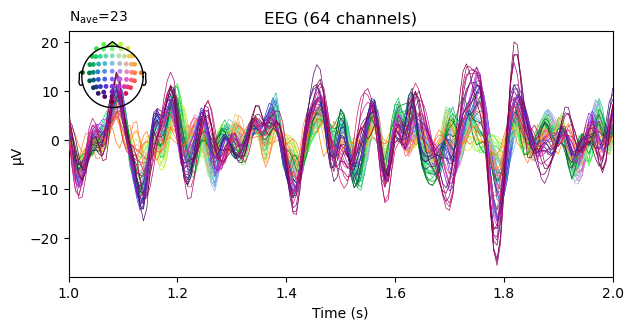

In [58]:
epochs_train['left'].average().plot();

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/Users/anushmutyala/opt/miniconda3/envs/torch/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


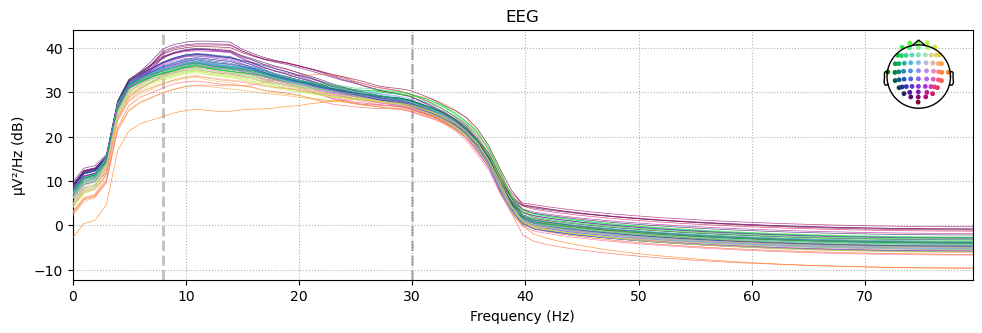

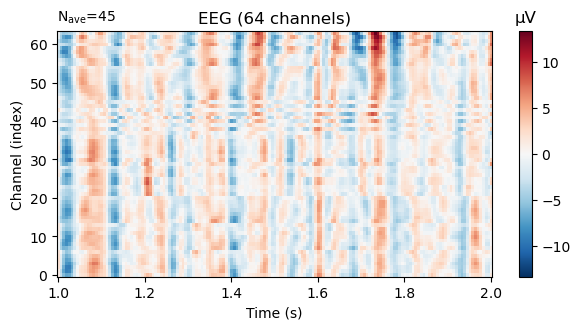

In [59]:
epochs_train.plot_psd();
epochs_train.average().plot_image();

In [100]:
psd_epoched, freqs = psd_array_welch(epochs_data, fmin=8.0, fmax=30.0, sfreq=160, n_fft=160)

psd_epoched.shape

Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


(45, 64, 23)

# Welch PSD Validation

In [121]:
# Helpers 

def dom_frequency(coeff, frate=128):
    #dom frequency
      w = np.fft.fft(coeff)
      freqs = np.fft.fftfreq(len(w))
      # print(freqs.min(), freqs.max())

      # Find the peak in the coefficients
      idx = np.argmax(np.abs(w))
      freq = freqs[idx]
      return abs(freq * frate)
      # 439.8975

def flatten(l):
    for item in l:
        try:
            yield from flatten(item)
        except TypeError:
            yield item


def filtered(data):

    data = data.astype('float64')

    DataFilter.perform_bandpass(data, fs, 12.6491106, 36.0, 4,
                            FilterTypes.BESSEL.value, 0)
    DataFilter.remove_environmental_noise(data, fs, NoiseTypes.SIXTY.value)

    return data
  
def featurize(batches, level=4):
  # for electrode in range(batches.shape[1]-1):
  #   for coeff in (wavedec(filtered(batches[:, electrode]), 'db2', 'zero', level=level)):
  #     # print(coeff.shape)
  #     yield [dom_frequency(coeff), hjorth_params(coeff), num_zerocross(coeff), spectral_entropy(coeff, 128, nperseg=128), pd.Series(coeff).mad(), hurst_rs(coeff), app_entropy(coeff), lyap_r(coeff, emb_dim=2), svd_entropy(coeff), corr_dim(coeff, emb_dim=2), sample_entropy(coeff), np.amin(coeff), np.amax(coeff), np.mean([np.amin(coeff), np.amax(coeff)]), np.mean(np.square(coeff)), np.mean(coeff), np.var(coeff), np.std(coeff)]

  return [[[dom_frequency(coeff), hjorth_params(coeff), num_zerocross(coeff), spectral_entropy(coeff, 128, nperseg=128), pd.Series(coeff).mad(), hurst_rs(coeff), app_entropy(coeff), lyap_r(coeff, emb_dim=2), svd_entropy(coeff), corr_dim(coeff, emb_dim=2), sample_entropy(coeff), np.amin(coeff), np.amax(coeff), np.mean([np.amin(coeff), np.amax(coeff)]), np.mean(np.square(coeff)), np.mean(coeff), np.var(coeff), np.std(coeff)] for coeff in wavedec(filtered(batches[:, electrode]), 'db2', 'zero', level=level)] for electrode in range(batches.shape[1]-1)]
# dom frequency doesn't work, spectral_entropy has nan, 

def psd_mne(batches):
  info = mne.create_info(14, 128, ch_types='eeg')
  psd, freqs = mne.time_frequency.psd_welch(mne.io.RawArray(batches.T, info))

  freq_splits = [np.where(freqs < 4), np.where((freqs >= 8) & (freqs <= 12)), np.where((freqs >= 12) & (freqs < 16)), np.where((freqs >= 16) & (freqs < 25)), np.where((freqs >= 25) & (freqs < 39))]

  return np.array([[[np.mean(electrode[band])] for band in freq_splits] for electrode in tqdm(psd)]).reshape(14, 5)

def discrete_ft(x, sfreq, window=None):
    #initial variables
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N) # col vector
    k = n.reshape((N, 1)) # row vector 
    M = np.exp((-2j * np.pi * k * n)/ N) # dft matrix
    freq = n/(N/sfreq)

    if window:
      return np.dot(M, x*window), np.fft.fft(x*window), freq
    else:
      return np.dot(M, x), np.fft.fft(x), freq

In [139]:
epochs_train = epochs.copy() # full length 
epochs_data = epochs_train.get_data()

first_channel = epochs_data[0,0, :]
first_channel = first_channel.flatten()
len(first_channel)

801

Welch's periodogram algorithm based on: https://www.osti.gov/servlets/purl/5688766

In [140]:
# Welch PSD 

def custom_welch_psd(x, fs, fmin, fmax, n_fft, win=None):
    return

N = len(first_channel) # length of the signal
fmin = 8
fmax = 30
fs = epochs.info['sfreq']
M = int((2/8)*fs) # window length long enough to cover at least 2 cycles of the lowest frequency of interest
# print(M)
S = M//2 # window step. 50% overlap is standard
seggs = []
K = (N-M)//S + 1 # number of segments

for i in range(K):
    # print(i*S, i*S+M)
    seggs.append(first_channel[i*S:i*S+M])

w = np.hanning(M)
W = np.sum(w**2) # normalize the PSD
freqs = np.fft.fftfreq(M, 1/fs)
print(freqs)

psd_seggs = np.array([np.abs(np.fft.fft(seg*w))**2/W for seg in seggs])
print(psd_seggs.shape)
welch_psd = np.mean(psd_seggs, axis=0)
print(welch_psd.shape)

       

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76. -80. -76. -72. -68. -64. -60. -56. -52.
 -48. -44. -40. -36. -32. -28. -24. -20. -16. -12.  -8.  -4.]
(39, 40)
(40,)


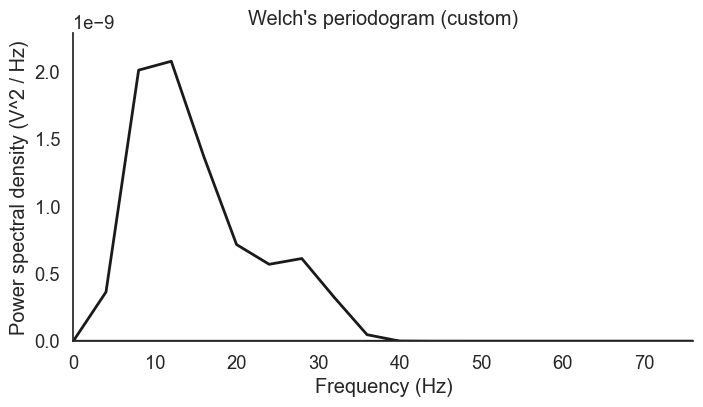

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, welch_psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, welch_psd.max() * 1.1])
plt.title("Welch's periodogram (custom)")
plt.xlim([0, freqs.max()])
sns.despine();
plt.show();

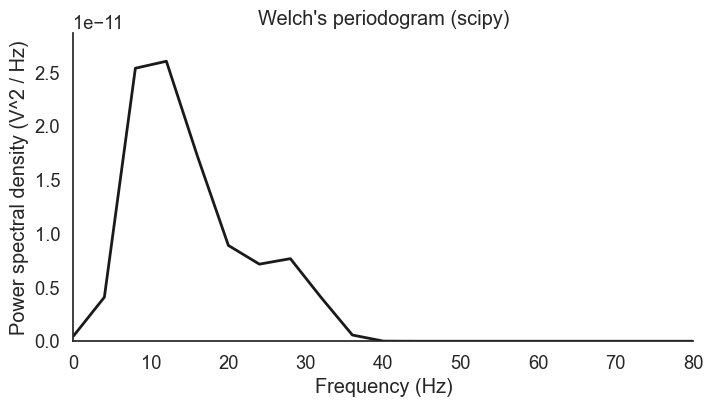

In [142]:
# test with scipy.signal.welch

from scipy import signal

# Define window length (4 seconds)
freqs, psd = signal.welch(first_channel, fs, nperseg=M, noverlap=S)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram (scipy)")
plt.xlim([0, freqs.max()])
sns.despine();
plt.show();

# Short Time Fourier Transform Spectrogram Validation

In [145]:
from scipy import signal

f, t, stft_arr = signal.stft(first_channel, fs, nperseg=M, noverlap=S)
print(t)

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125 1.25  1.375
 1.5   1.625 1.75  1.875 2.    2.125 2.25  2.375 2.5   2.625 2.75  2.875
 3.    3.125 3.25  3.375 3.5   3.625 3.75  3.875 4.    4.125 4.25  4.375
 4.5   4.625 4.75  4.875 5.    5.125]


# Common Spatial Pattern Validation

For CSP to be an appropriate method for this dataset, we need to test for multivariate normality. Essentially, all electrode data should follow a  joint gaussian distribution. 

In [344]:
epochs_train = epochs.copy() # full length 
epochs_data = epochs_train.get_data()
print(epochs_data.shape)

X = epochs_data[0, :, :].T
X.shape # (rows, cols)

(45, 64, 801)


(801, 64)

In [220]:
# univariate normality
from scipy.stats import normaltest

gaussian_elecs = {}

for i in range(X.shape[1]):
  stat, p = normaltest(X[:, i])
  if p > 0.05:
    gaussian_elecs[i] = ('Electrode %.2i, Statistics=%.3f, p=%.3f \n' % (i, stat, p))

print(len(gaussian_elecs))
for elec in gaussian_elecs:
  print(gaussian_elecs[elec])

# stat, p = normaltest(X[:, 0]) # first channel
# print('Statistics=%.3f, p=%.3f' % (stat, p))
# if p > 0.05:
#     print('Gaussian')


10
Electrode 02, Statistics=5.842, p=0.054 

Electrode 03, Statistics=3.920, p=0.141 

Electrode 32, Statistics=2.577, p=0.276 

Electrode 33, Statistics=1.613, p=0.446 

Electrode 34, Statistics=4.489, p=0.106 

Electrode 35, Statistics=5.406, p=0.067 

Electrode 41, Statistics=1.620, p=0.445 

Electrode 43, Statistics=1.279, p=0.528 

Electrode 45, Statistics=1.399, p=0.497 

Electrode 54, Statistics=2.163, p=0.339 



In [222]:
# mutlivariate normality test
import pingouin as pg
import numpy as np

normal_data = X[:, list(gaussian_elecs.keys())]
print(normal_data.shape)

# Compute the Henze-Zirkler test statistic and p-value
stat, pval, is_normal = pg.multivariate_normality(X, alpha=0.05)

# Print the results
print('Henze-Zirkler test statistic: %.2f' % stat)
print('p-value: %.4f' % pval)
print('Is the distribution normal? %s' % is_normal)


(801, 10)
Henze-Zirkler test statistic: 1.00
p-value: 0.0000
Is the distribution normal? False


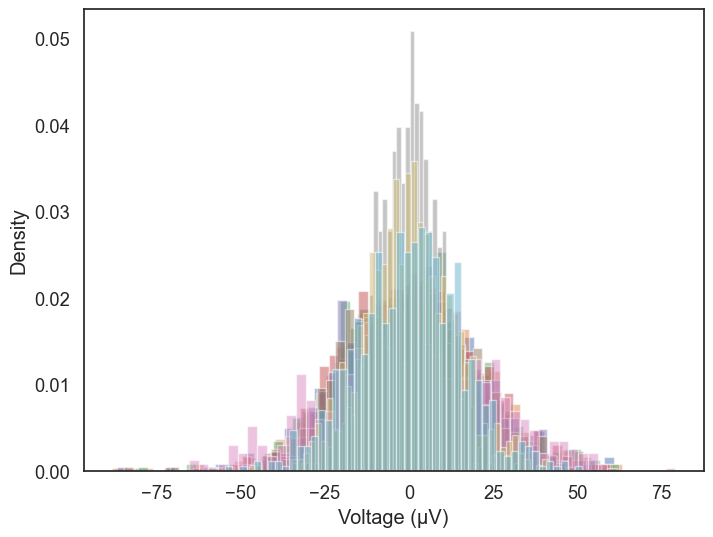

In [223]:
import matplotlib.pyplot as plt
import numpy as np

# Select the channels you want to analyze (e.g., channels 0, 1, and 2)
channels_data = X[:, list(gaussian_elecs.keys())]

# Set the scaling factor to convert from volts to microvolts
scaling_factor = 1e6

# Plot the voltage distribution PDF of all channels in a single plot
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(channels_data.shape[1]):
    ax.hist(channels_data[:, i]*scaling_factor, bins=50, density=True, alpha=0.5, label=f'Channel {i}')
    ax.set_xlabel('Voltage (μV)')
    ax.set_ylabel('Density')
if channels_data.shape[1] < 10:
    ax.legend()
plt.show()


(45, 801)
(45, 801)
(2, 18423)
0.9508181105324974


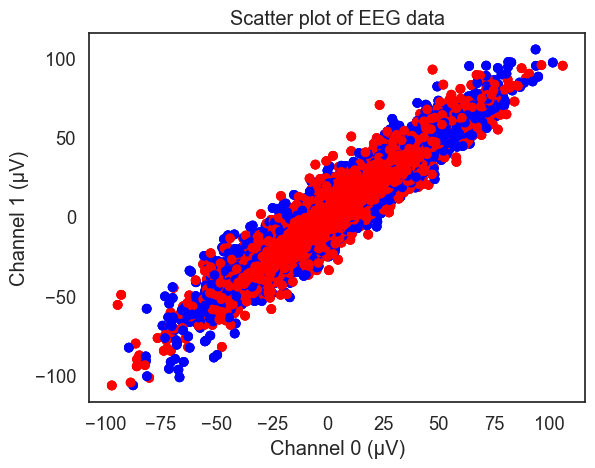

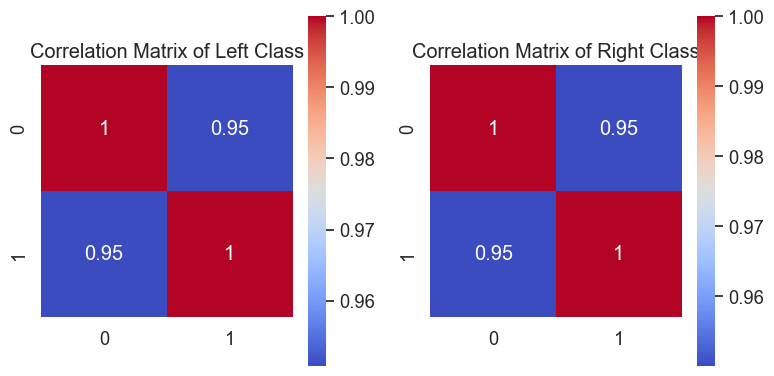

In [345]:
# scatter plot between channels and classes 
import seaborn as sns

# extract class labels
ch_1 = epochs_data[:, 0, :]
ch_2 = epochs_data[:, 1, :]
labels = epochs.events[:, -1] - 2
label_left_idx = np.where(labels == 0)[0]
label_right_idx = np.where(labels == 1)[0]
labels = labels.reshape(-1, 1) * np.ones((1, ch_1.shape[1])) 

print(labels.shape)
print(ch_1.shape)

# Set the scaling factor to convert from volts to microvolts
scaling_factor = 1e6

# Create a scatter plot with color-coded points
plt.scatter(ch_1.flatten()*scaling_factor, ch_2.flatten()*scaling_factor, c=labels.flatten(), cmap='bwr')

# Add labels and a title
plt.xlabel('Channel 0 (μV)')
plt.ylabel('Channel 1 (μV)')
plt.title('Scatter plot of EEG data')

# inputs to cov and corr mats 
inp_left = np.stack((ch_1[label_left_idx, :].flatten(), ch_2[label_left_idx, :].flatten()))
inp_right = np.stack((ch_1[label_right_idx, :].flatten(), ch_2[label_right_idx, :].flatten()))
print(inp_left.shape)

# Calculate cov matrix of two channels
cov_left = np.cov(inp_left)
cov_right = np.cov(inp_right)

# cov values are super small so convert to correlation between [-1, 1]
# cor_left = cov_left / np.sqrt(cov_left[0,0] * cov_left[1,1])
# print(cor_left)
cor_left = np.corrcoef(inp_left)
cor_right = np.corrcoef(inp_right)
print(cor_left[0, 1])

# Plot the correlation matrices as heatmaps
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(cor_left, cmap='coolwarm', annot=True, square=True, ax=axs[0])
sns.heatmap(cor_right, cmap='coolwarm', annot=True, square=True, ax=axs[1])
axs[0].set_title('Correlation Matrix of Left Class')
axs[1].set_title('Correlation Matrix of Right Class')
plt.tight_layout()

plt.show();


(64, 18423)
0.9508181105324974


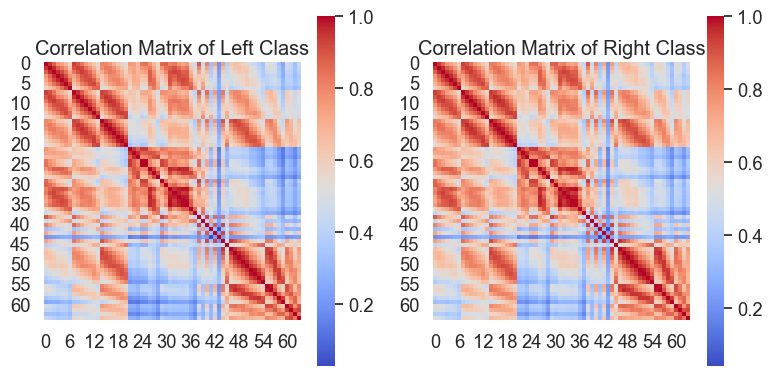

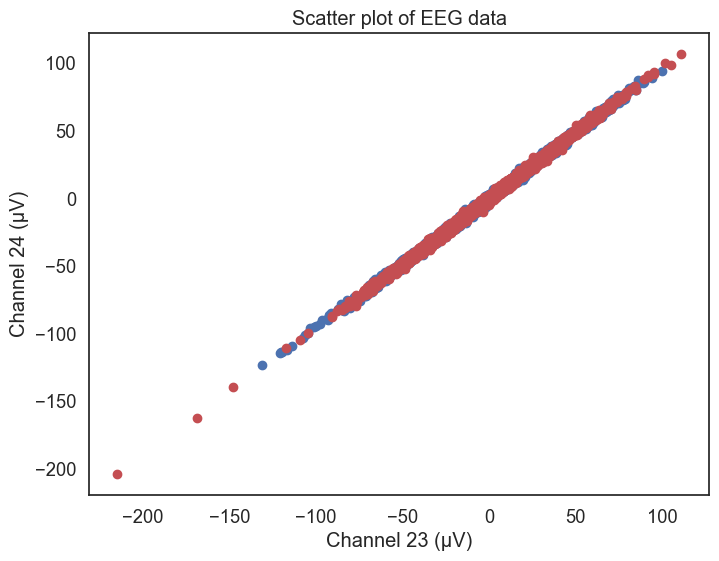

In [361]:
# 64 x 64 correlation matrix heatmap

# reshape epochs_data such that it is (64, n) where is n is flattened epochs
epoch_data_left = epochs_data[label_left_idx, :, :]
left_flat = np.moveaxis(epoch_data_left, 1, 0).reshape(64, -1)
epoch_data_right = epochs_data[label_right_idx, :, :]
right_flat = np.moveaxis(epoch_data_right, 1, 0).reshape(64, -1)
print(left_flat.shape)

# calculate correlation matrix
cor_left = np.corrcoef(left_flat)
cor_right = np.corrcoef(right_flat)
print(cor_left[0, 1])


# print(len(left_flat[0, :]))
# print(len(left_flat[1, :]))
# print(len(right_flat[0, :]))
# print(len(right_flat[1, :]))

# plot heatmap
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.heatmap(cor_left, cmap='coolwarm', square=True, ax=axs[0])
sns.heatmap(cor_right, cmap='coolwarm', square=True, ax=axs[1])
axs[0].set_title('Correlation Matrix of Left Class')
axs[1].set_title('Correlation Matrix of Right Class')
plt.tight_layout()

# view scatter plot of channel 1 and 2 for left and right classes on a new plot
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(left_flat[24, :]*scaling_factor, left_flat[25, :]*scaling_factor, c='b', label='left')
plt.scatter(right_flat[24, :]*scaling_factor, right_flat[25, :]*scaling_factor, c='r', label='right')

# Add labels and a title
plt.xlabel('Channel 23 (μV)')
plt.ylabel('Channel 24 (μV)')
plt.title('Scatter plot of EEG data')

plt.show();


In [360]:
# Find electrode pair with highest correlation in left class
max_cor = 0
max_cor_idx = 0
for i in range(32):
    for j in range(32):
        if i != j and cor_left[i, j] > max_cor:
            max_cor = cor_left[i, j]
            max_cor_idx = [i, j]

print(max_cor)
print(max_cor_idx)

# Find electrode pair with highest correlation in right class
max_cor = 0
max_cor_idx = 0
for i in range(32):
    for j in range(32):
        if i != j and cor_right[i, j] > max_cor:
            max_cor = cor_right[i, j]
            max_cor_idx = [i, j]

print(max_cor)
print(max_cor_idx)


0.9986456220880119
[25, 24]
0.9986441238494531
[25, 24]


# Preprocessing Loop